#Locally adaptive Bayesian covariance regression:
## Making test data

Here, we follow the algorithm given in [Durante, Scarpa, and Dunson (2014)](http://jmlr.org/papers/volume15/durante14a/durante14a.pdf). The description in the paper is a bit sketchy, but we are following Section 4.1.

In [1]:
using PyPlot
using Distributions
plt.style[:use]("ggplot")
srand(12349)

Base.Random.MersenneTwister(Base.dSFMT.DSFMT_state(Int32[-935566649,1073237820,1934592167,1072843350,-447405271,1073164189,-1188411050,1073684654,-1129415430,1073113899  …  1010550615,1073350122,216823553,1072780241,93702220,-2017834829,-1885108960,970019212,382,32674]),[1.46642,1.82008,1.47523,1.48096,1.25122,1.38373,1.55612,1.60794,1.41825,1.48366  …  1.95127,1.55197,1.9562,1.66325,1.96952,1.13942,1.00994,1.55485,1.30676,1.85105],382,UInt32[0x0000303d])

### Set parameters

In [2]:
Np = 5  # dimension of observation 
NL = 2  # Left dimension of \Theta
NK = 2  # Right dimension of \Theta

2

### Make $\xi(t)$

The $\Xi(t)$ matrix is $L \times K$. Each $\xi_{lk}(t), t \in [0, 1]$ is like a "bumps" function from [Donoho and Johnstone (1994)](http://biomet.oxfordjournals.org/content/81/3/425.short).

In [3]:
# bump kernel function
function K_bumps(t::Float64)
    return (1 + abs(t))^-4
end

# make weighted kernel function
function make_curve(nbumps, kern, max_scale, weight_range, tobs)
    kern_locs = sort(rand(nbumps))
    kern_scales = max_scale * rand(nbumps)
    kern_list = [(t -> kern((t - ti) / s)) for (ti, s) in zip(kern_locs, kern_scales)]
    w_min, w_max = weight_range
    weights = w_min + (w_max - w_min) * rand(nbumps)
    K_mat = [f(t) for f in kern_list, t in tobs]
    return weights' * K_mat
end

make_curve (generic function with 1 method)

Sanity check:

(1001

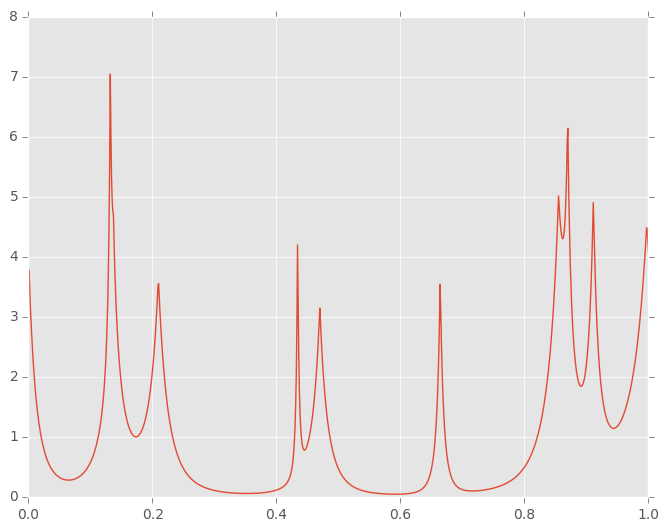

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3246906d0>

,)


In [4]:
tobs = collect(0:0.001:1)  # observation points
Nt = length(tobs)
println(size(tobs))

bumps = make_curve(11, K_bumps, 0.1, (3, 4.5), tobs)

plot(tobs, bumps')

Now make a matrix of these:

In [5]:
ξ = Array(Float64, Nt, NL, NK)

for l in 1:NL, k in 1:NK
    ξ[:, l, k] = make_curve(11, K_bumps, 0.1, (3, 6), tobs)
end

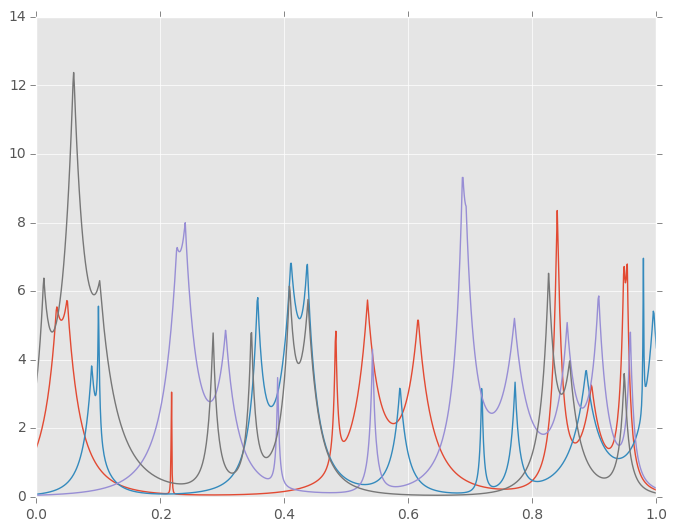

In [6]:
for l in 1:NL, k in 1:NK
    plot(tobs, ξ[:, l, k])
end

### Make $\psi(t)$

The $K$-vector $\Psi(t)$ is the mean of each dictionary element, drawn from a Gaussian process with standard $e^{-|x-x'|^2/\kappa^2}$ kernel.

In [7]:
# make enormous covariance matrix
κ = 0.1  # is 10 in Durante et al., but we include rescaling by 100
dist_mat = Float64[exp(-(ti - tj)^2/κ^2)  for ti in tobs, tj in tobs]

# handle near singularity of matrix by adding a ridge noise term
toler = 1e-9
dist_mat += scale(toler, eye(Nt))  # add a ridge term

ψ = Array(Float64, Nt, NK)
ψ_scale = 1.  # something like the SNR, since \nu is assumed to have unit variance

for k in 1:NK
    ψ[:, k] = ψ_scale * rand(MvNormal(dist_mat))
end

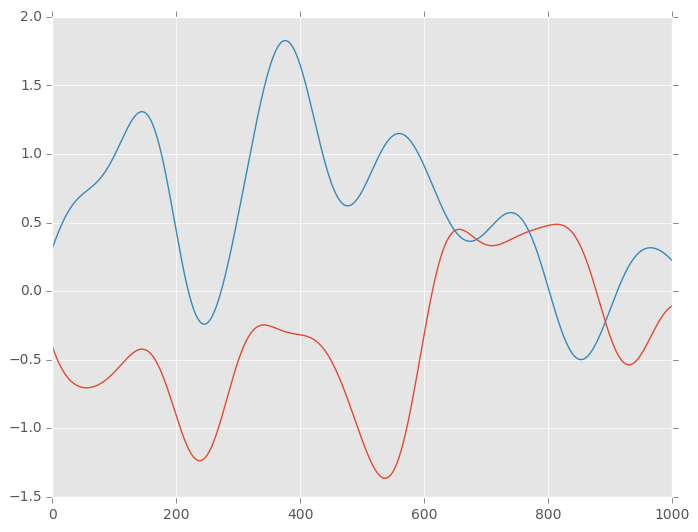

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32722b9d0>
 PyObject <matplotlib.lines.Line2D object at 0x32722bc50>

In [8]:
plot(ψ)

### Make $\eta$

We want $\eta(t) = \psi(t) + \nu_t$ with $\nu_t \sim \mathcal{N}(0, \mathbb{1}_K)$. 

In [9]:
η = ψ + randn(size(ψ)...);

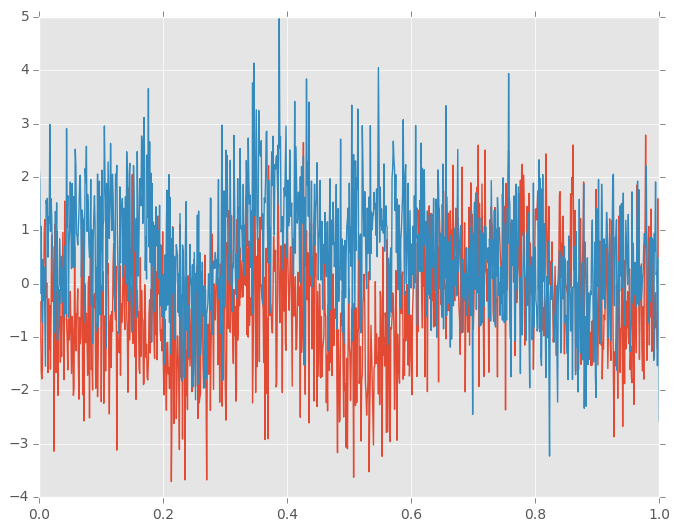

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x327468310>
 PyObject <matplotlib.lines.Line2D object at 0x327468590>

In [10]:
plot(tobs, η)

### Make $\Theta$

From Durante et al., we have 

$$\begin{align}
\theta_{jl} &\sim \mathcal{N}(0, \phi_{jl}^{-1} \tau_l^{-1}) \\
\phi_{jl} &\sim \mathrm{Ga}\left(\frac{3}{2}, \frac{3}{2} \right) \\
\tau_l &= \prod_h^l \vartheta_h \\
\vartheta_1 &\sim \mathrm{Ga}(a_1, 1) \\
\vartheta_h &\sim \mathrm{Ga}(a_2, 1) \quad h \ge 2
\end{align}$$

In [11]:
function draw_θ(p, L, a1, a2)
    ϕ = rand(Gamma(3//2, 3//2), p, L)
    th = Array(Float64, L)
    th[1] = rand(Gamma(a1, 1))
    th[2:end] = rand(Gamma(a2, 1), L - 1)
    τ = cumprod(th)
    σ = 1 ./ map(sqrt, (ϕ .* τ'))
    θ = randn(p, L) .* σ
    return θ
end

draw_θ (generic function with 1 method)

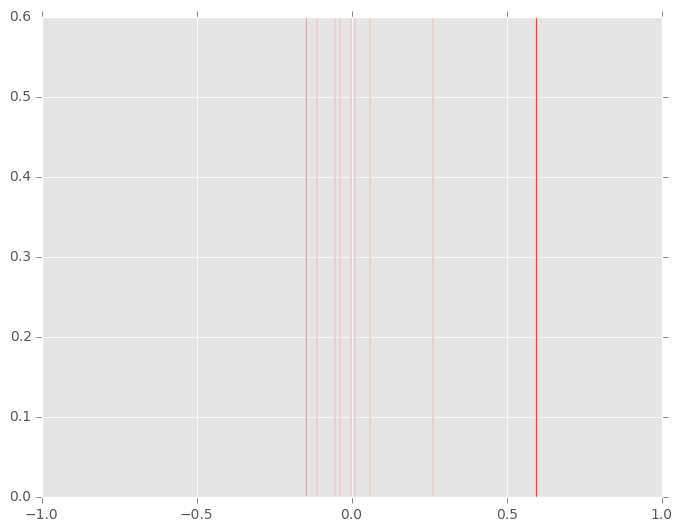

(-1,1)

In [12]:
Theta = draw_θ(Np, NL, 10, 10)

plt.hist(Theta[:], 200, normed=true)
plt.ylim(0, 0.6)
plt.xlim(-1, 1)

In [13]:
Theta

5x2 Array{Float64,2}:
 -0.111543   -0.0572978 
  0.596943   -0.00368538
 -0.147349   -0.0359161 
  0.258564    0.0584459 
 -0.0046219   0.0115272 

### Make $\Sigma_0$

This is the channel-specific piece of the covariance matrix.

In [14]:
prec0 = rand(Gamma(1, 0.1), Np)

Σ0 = 0.1^2 * diagm(1 ./ prec0)

5x5 Array{Float64,2}:
 0.178095  0.0        0.0       0.0      0.0     
 0.0       0.0722083  0.0       0.0      0.0     
 0.0       0.0        0.208521  0.0      0.0     
 0.0       0.0        0.0       0.11423  0.0     
 0.0       0.0        0.0       0.0      0.236402

## Simulate data

We use the model given by 

$$\begin{align}
\eta(t) &= \psi(t) + \nu_t \\
y(t) &= \Theta \xi(t) \eta(t) + \epsilon_t \\
\epsilon_t &\sim \mathcal{N}(0, \Sigma_0) \\
\mu(t) &= \Theta \xi(t) \psi(t) \\
\Sigma(t) &= \Theta \xi \xi^\top \Theta^\top + \Sigma_0
\end{align}$$

In [15]:
y = Array(Float64, Nt, Np)
μ = similar(y)
Σ = Array(Float64, Nt, Np, Np)
noise = rand(MvNormal(Σ0), Nt)

for t in 1:Nt
    ThX = Theta * slice(ξ, t, :, :)
    y[t, :] = ThX * slice(η, t, :) + slice(noise, :, t)
    μ[t, :] = ThX * slice(ψ, t, :)
    Σ[t, :, :] = ThX * ThX' + Σ0
end

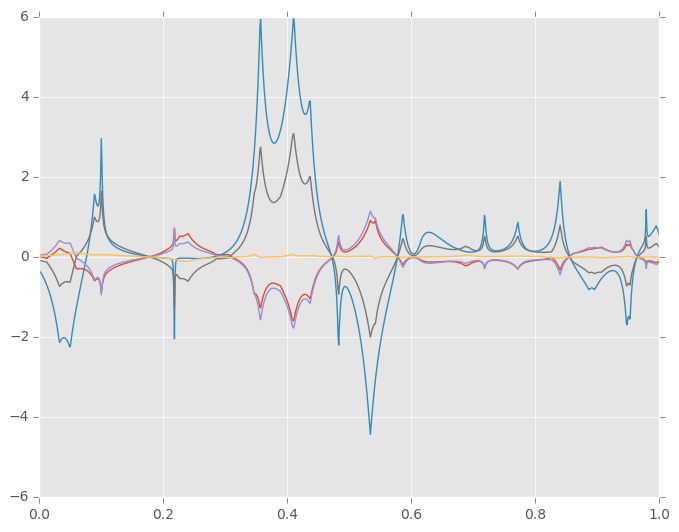

5-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x327d816d0>
 PyObject <matplotlib.lines.Line2D object at 0x327d81950>
 PyObject <matplotlib.lines.Line2D object at 0x327d81b90>
 PyObject <matplotlib.lines.Line2D object at 0x327d81d50>
 PyObject <matplotlib.lines.Line2D object at 0x327d81f10>

In [16]:
plot(tobs, μ)

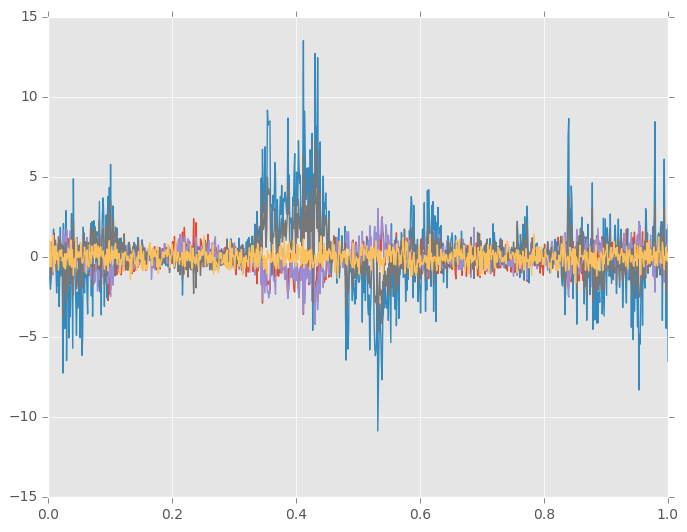

5-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3281c5110>
 PyObject <matplotlib.lines.Line2D object at 0x3281c5390>
 PyObject <matplotlib.lines.Line2D object at 0x3281c55d0>
 PyObject <matplotlib.lines.Line2D object at 0x3281c5790>
 PyObject <matplotlib.lines.Line2D object at 0x3281c5950>

In [17]:
plot(tobs, y)

### Write out data

In [18]:
using HDF5

In [19]:
fid = h5open("data/labcr_test_data.jld", "w")

grp = fid["/"]
grp["y"] = y'
grp["theta"] = Theta
grp["psi"] = ψ
grp["xi"] = ξ
grp["Σ0"] = Σ0
grp["tobs"] = tobs
grp["mu"] = μ
grp["Sigma"] = Σ

close(fid)